In [91]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from nltk.stem import WordNetLemmatizer
from matplotlib import pyplot as plt
import numpy as np
import re
import seaborn as sns
import sklearn


In [92]:
print(pd. __version__)

2.0.3


In [93]:
train = pd.read_csv('data/BBC News Train.csv')
test = pd.read_csv('data/BBC News Test.csv')

train.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [94]:
print('Training Data Size:', train.shape)
print('Number of Unique Training Data Rows:', train['Text'].nunique())

train.drop_duplicates(subset='Text', inplace=True, keep='first')
print('New Training Data Size:', train.shape)

train.head()

Training Data Size: (1490, 3)
Number of Unique Training Data Rows: 1440
New Training Data Size: (1440, 3)


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [95]:
# Any Null Values?
np.any(train.isna()) # False
np.any(test.isna())  # False

False

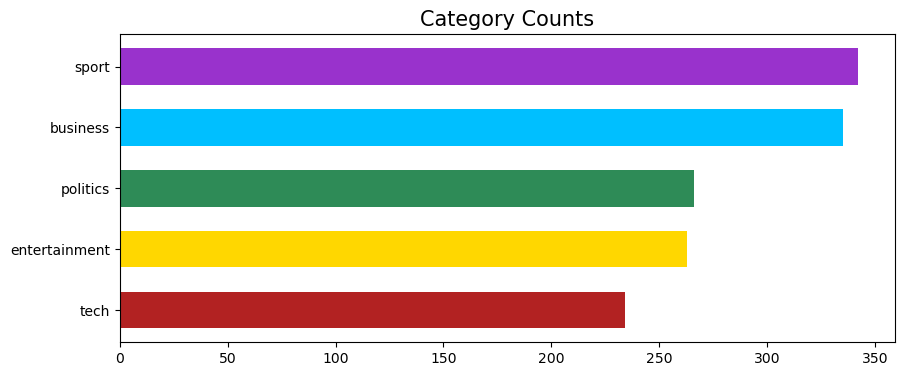

In [96]:
# Category Counts
group_counts = train.Category.value_counts()
bar_colors = ['firebrick', 'gold', 'seagreen', 'deepskyblue', 'darkorchid']

fig, ax = plt.subplots(figsize=(10, 4))

bar_height = 0.6

reversed_group_counts = group_counts.iloc[::-1]

ax.barh(reversed_group_counts.index, reversed_group_counts.values, color=bar_colors, height=bar_height)

ax.set_title('Category Counts', fontsize=15)
plt.show()

In [33]:
#This is where I will clean the text, but removing numbers, punctuation, and then lemmatizing the text

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    lemmatizer = WordNetLemmatizer()
    lemmatizer.lemmatize(text)
    return text

df = train.copy()
df.Text = df.Text.apply(clean_text)

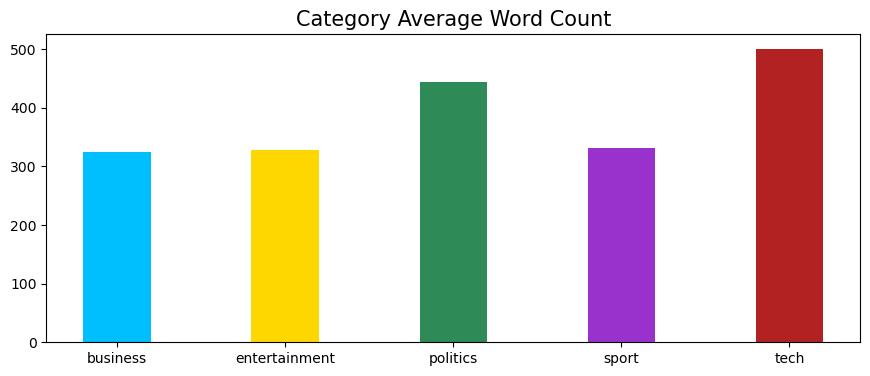

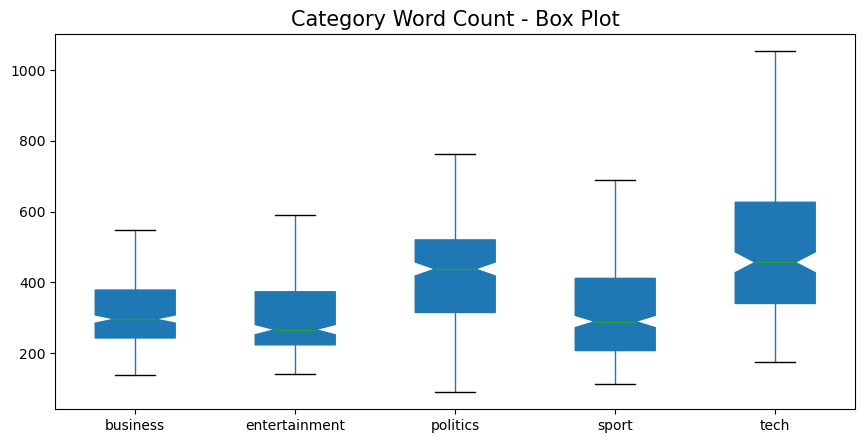

In [42]:
# I am going to calculate the average word count by the category.

bar_colors = ['deepskyblue', 'gold', 'seagreen', 'darkorchid', 'firebrick']

df['word_count'] = [len(words) for words in df['Text'].str.split()]
categoryWordCounts = df.groupby('Category')['word_count'].mean()

# visualization 1:  mean word count by Group
fig, ax = plt.subplots(figsize=(10.5,4))
bar_width = 0.4

ax.bar(categoryWordCounts.index, categoryWordCounts.values, color=bar_colors, width=bar_width)
ax.set_title('Category Average Word Count', fontsize=15)
plt.show()

box_colors = ['deepskyblue', 'gold', 'seagreen', 'darkorchid', 'firebrick']

# visualization 2:  Boxplot of Word Count by Group
bplot1 = df.boxplot(by='Category', column='word_count', showfliers=False, grid=False, notch=True, figsize=(10, 5), patch_artist=True)

plt.title('Category Word Count - Box Plot', fontsize=15)
plt.xlabel('')
plt.suptitle('')
plt.show()


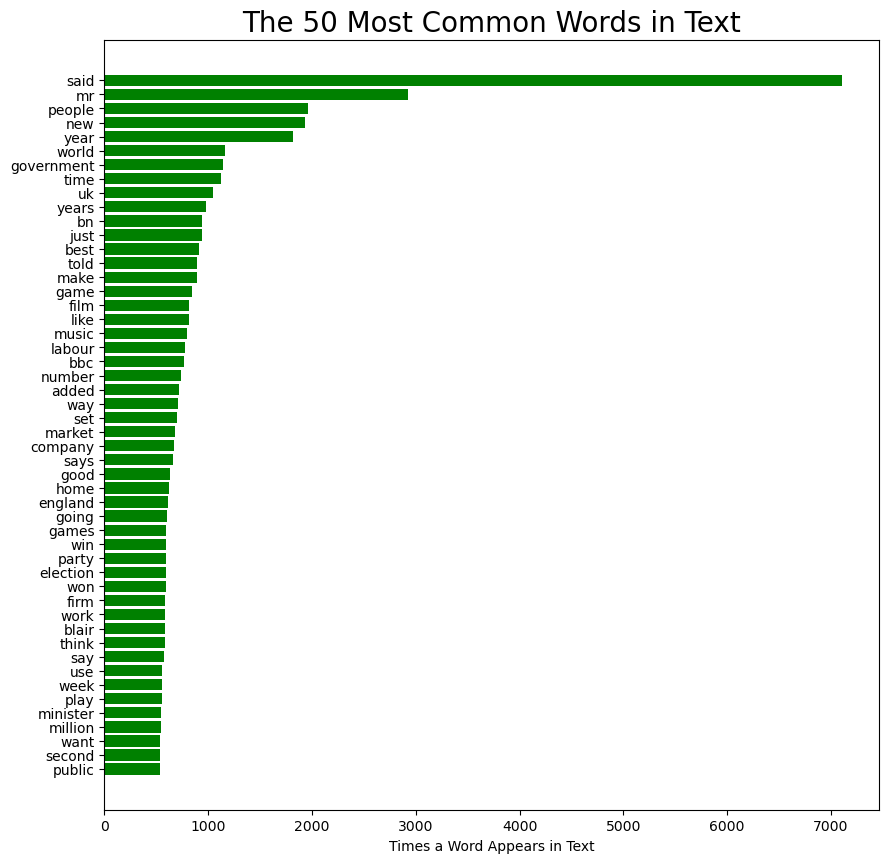

In [43]:
# Lets look at what the most common words are in the text

n = 50
mostCommonWordVector = CountVectorizer(stop_words='english', max_features=n)
X = mostCommonWordVector.fit_transform(df.Text)
words = mostCommonWordVector.get_feature_names_out()
counts = X.toarray().sum(axis=0)

# Visualization

idx = np.argsort(counts)

fig, ax = plt.subplots(figsize=(10,10))
ax.barh(y=words[idx], width=counts[idx], color='green')  # compare with plt.bar(x=words, height=counts)
ax.set_title('The 50 Most Common Words in Text', fontsize=20)
ax.set_xlabel('Times a Word Appears in Text');



In [44]:

wordCountVector = CountVectorizer(stop_words='english')
X = wordCountVector.fit_transform(train.Text)
wordCounts = X.toarray().sum(axis=0)

print('total # words:', len(wordCounts))
print('<= 1000 count:', (wordCounts <= 1000).sum())
print('<= 100 count:', (wordCounts <= 100).sum())
print('<= 10 count:', (wordCounts <= 10).sum())
print('<= 5 count:', (wordCounts <= 5).sum())
print('<= 2 count:', (wordCounts <=2).sum())
print(' = 1 count:', (wordCounts ==1).sum())

total # words: 24456
<= 1000 count: 24451
<= 100 count: 23922
<= 10 count: 19807
<= 5 count: 17221
<= 2 count: 12884
 = 1 count: 9196


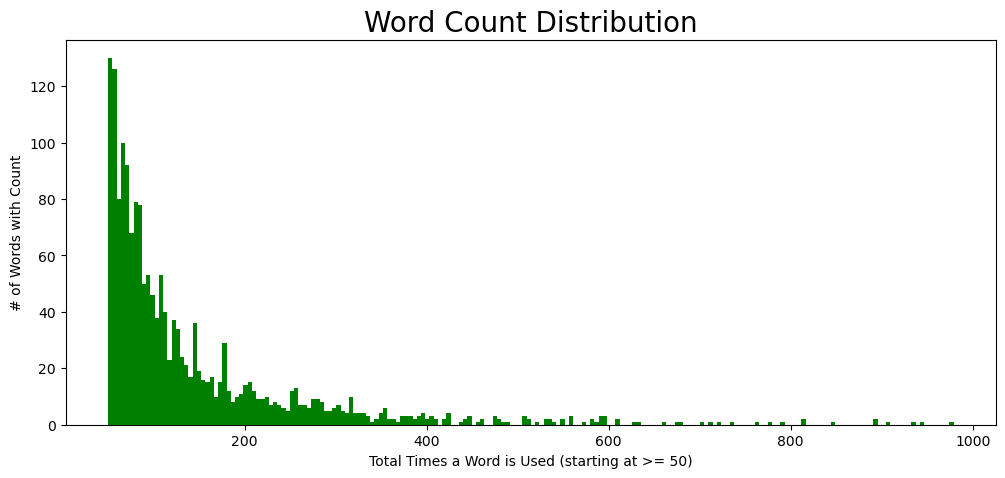

In [45]:
totalWordsCombined = pd.concat([train, test], axis=0, ignore_index=True)
df = totalWordsCombined.copy()
df.Text = df.Text.apply(clean_text)

countVector = CountVectorizer(stop_words='english')
X = countVector.fit_transform(df.Text)
counts = X.toarray().sum(axis=0)

fig, ax = plt.subplots(figsize=(12,5))

ax.hist(counts[(counts >= 50) & (counts <= 1000)], bins=200, color='green')
ax.set_title('Word Count Distribution', fontsize=20)
ax.set_xlabel('Total Times a Word is Used (starting at >= 50)')
ax.set_ylabel('# of Words with Count');



In [53]:
# Building datasets

# Note:  train and test data sets imported above
# Note:  helper function clean_text defined above

# Combine train and test sets

full_set = pd.concat([train, test], axis=0, ignore_index=True)


fitTransformVector = TfidfVectorizer(lowercase=True, preprocessor=clean_text, ngram_range=(1,2), max_df=0.9, min_df=2, stop_words='english')
X = fitTransformVector.fit_transform(full_set.Text)

In [54]:
# Learn NMF model

nmf_model = NMF(n_components=5, init='nndsvda', max_iter=500, random_state=0)
nmf_model.fit(X)

# Show the top n words for each topic

n = 25
for index, topic in enumerate(nmf_model.components_):
    print(f'Here are the top 25 words for index: {index}')
    print([vec.get_feature_names_out()[i] for i in topic.argsort()[-n:]])
    print()

Here are the top 25 words for index: 0
['league', 'nations', 'games', 'final', 'good', 'robinson', 'chelsea', 'season', 'world', 'injury', 'club', 'coach', 'france', 'match', 'team', 'play', 'rugby', 'players', 'said', 'ireland', 'cup', 'wales', 'win', 'game', 'england']

Here are the top 25 words for index: 1
['tony blair', 'people', 'tony', 'lib', 'mr howard', 'leader', 'campaign', 'tories', 'tory', 'tax', 'chancellor', 'prime minister', 'prime', 'minister', 'howard', 'government', 'mr brown', 'mr blair', 'said', 'party', 'brown', 'election', 'blair', 'labour', 'mr']

Here are the top 25 words for index: 2
['india', 'profits', 'quarter', 'rates', 'rate', 'analysts', 'rise', 'government', 'firm', 'dollar', 'shares', 'company', 'prices', 'china', 'market', 'economic', 'yukos', 'year', 'sales', 'bank', 'oil', 'economy', 'growth', 'said', 'bn']

Here are the top 25 words for index: 3
['music', 'nominated', 'album', 'named', 'movie', 'oscars', 'ceremony', 'british', 'year', 'prize', 'star

In [97]:

topicResults = nmf_model.transform(X)


topicPredictionResults = topic_results.argmax(axis=1)
full_set['Topic'] = topicPredictionResults



In [98]:



full_set.head(20)

topicLabels = {
    0: 'sport',
    1: 'politics',
    2: 'business',
    3: 'entertainment',
    4: 'tech'
}

full_set['Topic Label'] = full_set['Topic'].map(topicLabels)



In [99]:


# Assign Topic Label to the Topic Number - by permutation

import itertools

def label_permute(true, pred):

    # permute the true (string) labels
    labels = np.unique(true)
    permutes = list(itertools.permutations(labels))

    best_acc = -1
    for perm in permutes:
        pred_map = [perm[i] for i in pred]  # map the predicted (ints) to permuted (str) labels
        acc = accuracy_score(true, pred_map)
        # acc = (true == pred_map).sum() / len(true)
        if acc > best_acc:
            best_acc = acc
            best_map = perm

    mapped = [best_map[i] for i in pred]

    mapping = dict(zip(range(len(best_map)), best_map))

    return best_acc, mapping, mapped



In [100]:



idx = full_set[full_set['Category'].notna()].index  # get the index of the "train" set with know Category labels

best_acc, mapping, mapped = label_permute(true=full_set.loc[idx]['Category'], pred=full_set.loc[idx]['Topic'])

full_set['Topic Label - perm'] = full_set['Topic'].map(mapping)

assert(np.all(full_set['Topic Label'] == full_set['Topic Label - perm']))



In [101]:
# Check Accuracy and Confusion Matrix

true = full_set[full_set.Category.notna()]['Category']
pred = full_set[full_set.Category.notna()]['Topic Label']

acc = accuracy_score(true, pred)
print('accuracy score:', acc)

conf_mat = confusion_matrix(true, pred)
# print(conf_mat)

accuracy score: 0.9222222222222223


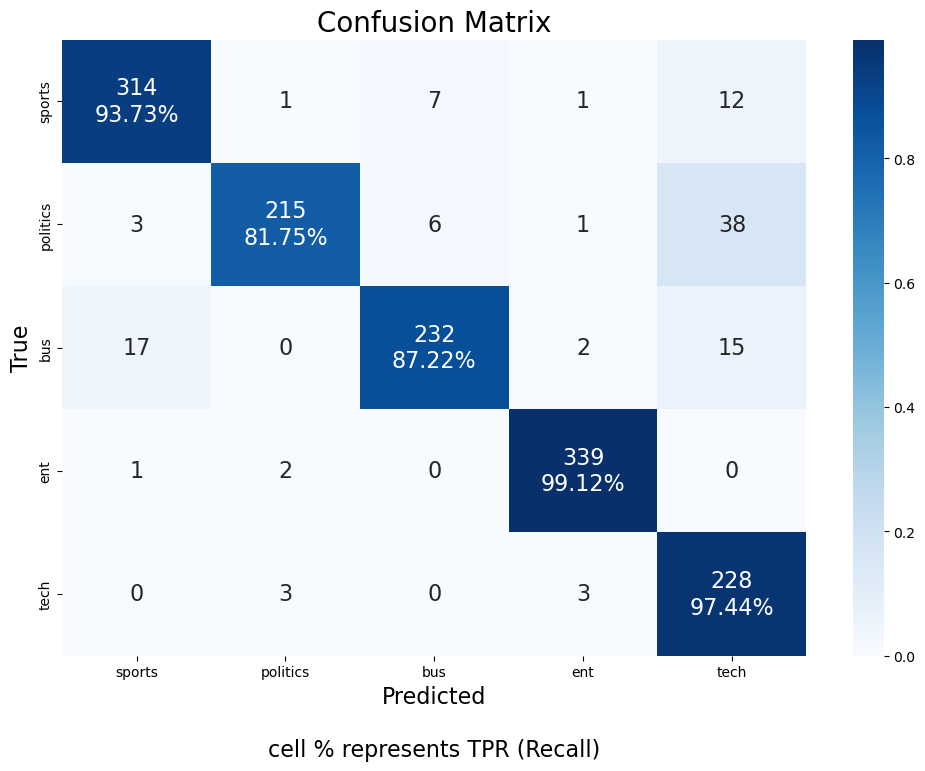

In [111]:


# Visualization of Confusion Matrix

labels = ['sports', 'politics', 'bus', 'ent', 'tech']
counts = conf_mat.flatten()
p = (conf_mat/np.sum(conf_mat, axis=1)).flatten()
accuracy = p[::6]

annots = [str(count) for count in counts]
for i in range(len(accuracy)):
    annots[i*6] = annots[i*6] + '\n' + f'{accuracy[i]:.2%}'

annots = np.asarray(annots).reshape(5,5)

fix, ax = plt.subplots(figsize=(12,8))
sns.heatmap(conf_mat/np.sum(conf_mat, axis=1), cmap='Blues', annot=annots, fmt='', annot_kws={'size': 16}, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted\n\ncell % represents TPR (Recall)', fontsize=16)
plt.ylabel('True', fontsize=16)
plt.title('Confusion Matrix', fontsize=20)
plt.show()



In [104]:
nmf_test_acc = 0.9222222222222223

In [112]:


'''
any of (ngram_range, max_df, min_df, max_features, solver, beta_loss) can be specified; otherwise uses default value
returns list of paramater values used and accuracy score
'''

def model_testing (ngram_range = (1,1), max_df = 1.0, min_df = 1, max_features = None, solver = 'cd', beta_loss = 'frobenius'):

    vec = TfidfVectorizer(lowercase=True, preprocessor=clean_text, ngram_range=ngram_range, max_df=max_df, min_df=min_df, max_features=max_features, stop_words='english')
    X_opt = vec.fit_transform(full_set.Text)

    nmf_opt = NMF(n_components=5, init='nndsvda', solver=solver, beta_loss=beta_loss, max_iter=500, random_state=0)
    nmf_opt.fit(X_opt)

    pred_opt = nmf_opt.transform(X_opt).argmax(axis=1)  # .map(topic_dict)
    pred_opt = np.vectorize(topic_dict.get)(pred_opt)   # map np.array to dict values
    idx_tr = full_set[full_set.Category.notna()].index
    pred_opt = pred_opt[idx_tr]

    acc_opt = accuracy_score(true, pred_opt)
    # print('accuracy score:', acc_opt)

    return [str(ngram_range), max_df, min_df, max_features, solver, beta_loss, acc_opt]



In [113]:
cols = ['ngram_range', 'max_df', 'min_df', 'max_features', 'solver', 'beta_loss', 'accuracy']
results_tuning = pd.DataFrame(columns=cols)

param_list = [
    {},
    {'ngram_range': (1,2), 'max_df': 0.9, 'min_df': 2},
    {'ngram_range': (1,2), 'max_df': 0.9, 'min_df': 2, 'solver': 'mu', 'beta_loss': 'kullback-leibler'},
    {'ngram_range': (1,2), 'max_df': 0.8, 'min_df': 5, 'solver': 'mu', 'beta_loss': 'kullback-leibler'},
    {'ngram_range': (1,2), 'max_df': 0.8, 'min_df': 10, 'solver': 'mu', 'beta_loss': 'kullback-leibler'},
    {'ngram_range': (1,2), 'max_df': 0.8, 'min_df': 20, 'solver': 'mu', 'beta_loss': 'kullback-leibler'},
    {'ngram_range': (1,2), 'max_df': 0.8, 'min_df': 20, 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'max_features': 100},
    {'ngram_range': (1,2), 'max_df': 0.8, 'min_df': 20, 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'max_features': 500},
    {'ngram_range': (1,2), 'max_df': 0.8, 'min_df': 20, 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'max_features': 1000}
]

for params in param_list:
    res = np.array([model_testing(**params)])
    # print(res)
    df = pd.DataFrame(res, columns=cols)
    results_tuning = pd.concat([results_tuning, df], ignore_index=True)

results_tuning.accuracy = results_tuning.accuracy.astype(float).round(5)
results_tuning.style.highlight_max(subset='accuracy')

ngram_range=(1,2)
max_df=0.9
min_df=2
max_features=None
solver='mu'
beta_loss='kullback-leibler'

In [114]:
vec = TfidfVectorizer(lowercase=True, preprocessor=clean_text, ngram_range=ngram_range, max_df=max_df, min_df=min_df, max_features=max_features, stop_words='english')
X_opt = vec.fit_transform(full_set.Text)

nmf_opt = NMF(n_components=5, init='nndsvda', solver=solver, beta_loss=beta_loss, max_iter=500, random_state=0)
nmf_opt.fit(X_opt)

pred_opt = nmf_opt.transform(X_opt).argmax(axis=1)  # .map(topic_dict)
pred_opt = np.vectorize(topic_dict.get)(pred_opt)   # map np.array to dict values
idx_tr = full_set[full_set.Category.notna()].index
pred_opt_tr = pred_opt[idx_tr]

acc_opt = accuracy_score(true, pred_opt_tr)
print('accuracy score:', acc_opt)

accuracy score: 0.9618055555555556


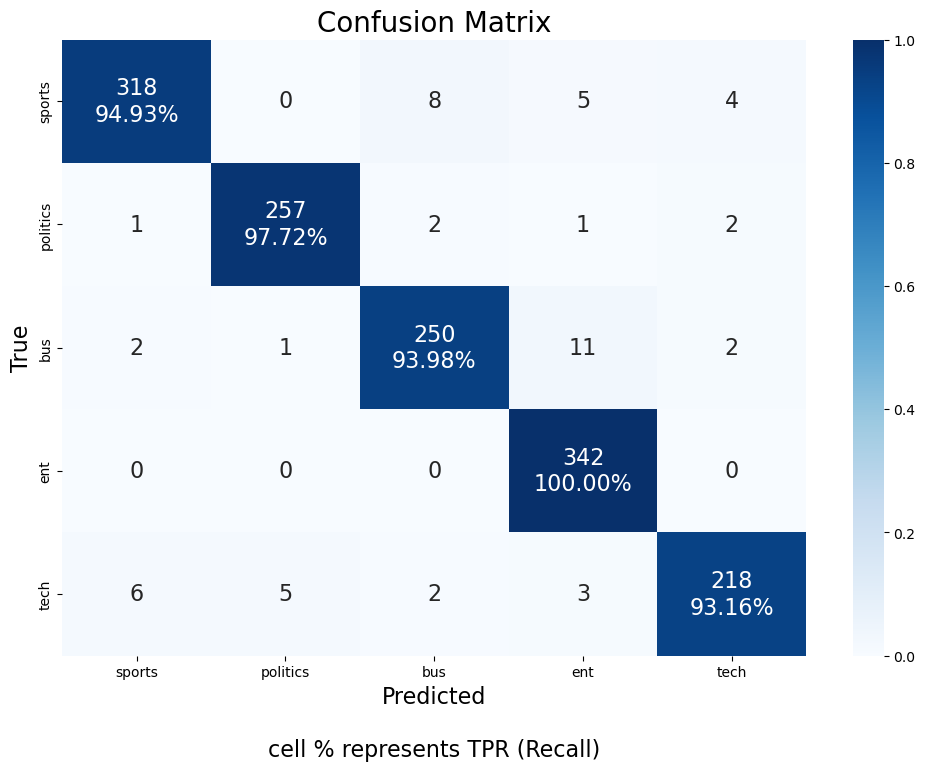

In [115]:
# Visualizaton of Confusion Matrix

conf_mat_opt = confusion_matrix(true, pred_opt_tr)
labels = ['sports', 'politics', 'bus', 'ent', 'tech']

counts = conf_mat_opt.flatten()
p = (conf_mat_opt/np.sum(conf_mat_opt, axis=1)).flatten()
accuracy = p[::6]

annots = [str(count) for count in counts]
for i in range(len(accuracy)):
    annots[i*6] = annots[i*6] + '\n' + f'{accuracy[i]:.2%}'

annots = np.asarray(annots).reshape(5,5)

fix, ax = plt.subplots(figsize=(12,8))
sns.heatmap(conf_mat_opt/np.sum(conf_mat_opt, axis=1), cmap='Blues', annot=annots, fmt='', annot_kws={'size': 16}, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted\n\ncell % represents TPR (Recall)', fontsize=16)
plt.ylabel('True', fontsize=16)
plt.title('Confusion Matrix', fontsize=20);

In [119]:
nmf_tuned_test_acc = 0.96734

In [121]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import sklearn.preprocessing as preprocessing


In [122]:
idx_train = full_set[full_set.Category.notna()].index
X_train = X[idx_train, :]
y = full_set.iloc[idx_train, :].Category  

In [123]:
classifiers = [MultinomialNB(), LogisticRegression(), SVC(), RandomForestClassifier()]
knn = KNeighborsClassifier(n_neighbors=5)

results_supervised = pd.DataFrame(columns = ['Model', 'CV-train'])

for clf in classifiers:
    cv = cross_val_score(clf, X_train, y, scoring='accuracy', cv=None, n_jobs=-1)      # default cv 'None' is 5-fold
    results_supervised.loc[len(results_supervised)] = {'Model': clf.__class__.__name__.replace('Classifier', ''), 'CV-train': cv.mean().round(5)}

X_train_normd = preprocessing.normalize(X_train, norm='l2')

clf=knn
cv = cross_val_score(clf, X_train_normd, y, scoring='accuracy', cv=None, n_jobs=-1)
results_supervised.loc[len(results_supervised)] = {'Model': clf.__class__.__name__.replace('Classifier', ''), 'CV-train': cv.mean().round(5)}

In [124]:
results_supervised.rename(columns={'CV-train': 'Accuracy'}, inplace=True)
results_supervised.loc[len(results_supervised)] = {'Model': 'NMF-train', 'Accuracy': acc.round(5)}
results_supervised.loc[len(results_supervised)] = {'Model': 'NMF-test', 'Accuracy': nmf_test_acc}
results_supervised.loc[len(results_supervised)] = {'Model': 'NMF-tuned-train', 'Accuracy': acc_opt.round(5)}
results_supervised.loc[len(results_supervised)] = {'Model': 'NMF-tuned-test', 'Accuracy': nmf_tuned_test_acc}
results_supervised.style.highlight_max(subset='Accuracy')

,Model,Accuracy
0,MultinomialNB,0.960420
1,LogisticRegression,0.965970
2,SVC,0.963190
3,RandomForest,0.954860
4,KNeighbors,0.942360
5,NMF-train,0.922220
6,NMF-test,0.922222
7,NMF-tuned-train,0.961810
8,NMF-tuned-test,0.967340
